In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # For better date formatting
import openpyxl 

In [2]:
def load_and_prepare_data(filepath, sheet_name=0):
    """
    Loads data from a single Excel file, and prepares it.
    Each pair of (Exchange Date, Price) columns is treated as a separate company.
    """
    try:
        xls = pd.ExcelFile(filepath)
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return pd.DataFrame(), [] # Return empty DataFrame and list
    df_raw = pd.read_excel(xls, sheet_name=sheet_name, header=0)

    all_company_data = []
    company_names = []

    if df_raw.shape[1] % 2 != 0:
        print(f"Warning: The Excel file {filepath} has an odd number of columns. Expecting Date/Price pairs.")
        # Process pairs and ignore the last column if odd.

    # Iterate through columns ensuring we don't go out of bounds for price_col_name
    for i in range(0, df_raw.shape[1] - (df_raw.shape[1] % 2) , 2):
        date_col_name = df_raw.columns[i]
        price_col_name = df_raw.columns[i+1]
        company_name = price_col_name # Assuming price column header is the company name

        company_df = df_raw[[date_col_name, price_col_name]].copy()
        company_df.columns = ['Date', 'Price'] # Standardize column names

        # Convert 'Date' column to datetime objects, handling potential errors
        company_df['Date'] = pd.to_datetime(company_df['Date'], errors='coerce')
        company_df.dropna(subset=['Date'], inplace=True) # Remove rows where date conversion failed

        # Remove rows where Price might be missing (e.g., before IPO) or non-numeric
        company_df['Price'] = pd.to_numeric(company_df['Price'], errors='coerce')
        company_df.dropna(subset=['Price'], inplace=True)

        if company_df.empty:
            # print(f"No valid data for columns {date_col_name}/{price_col_name} in {filepath}") # Can be verbose
            continue

        company_df.set_index('Date', inplace=True)
        company_df.rename(columns={'Price': company_name}, inplace=True)

        if not company_df.empty:
            all_company_data.append(company_df)
            company_names.append(company_name)

    if not all_company_data:
        # print(f"No company data successfully processed from {filepath}") # Can be verbose
        return pd.DataFrame(), []

    merged_df = pd.concat(all_company_data, axis=1, join='outer')
    merged_df.sort_index(inplace=True)
    return merged_df, company_names

def calculate_equal_weighted_index(price_data_df, base_value=100):
    """
    Calculates an equal-weighted index.
    """
    if price_data_df.empty:
        # print("Cannot calculate index from empty price data.") # Can be verbose
        # Return empty structures that downstream functions expect
        return pd.Series(dtype=float), pd.DataFrame(dtype=float), pd.DataFrame(dtype=float), pd.Series(dtype=int)

    filled_price_data = price_data_df.ffill()
    daily_returns = filled_price_data.pct_change()
    num_companies_active = filled_price_data.notna().sum(axis=1)
    index_daily_returns = daily_returns.mean(axis=1) # Auto handles NaNs for equal weighting

    first_valid_date = None
    if not num_companies_active[num_companies_active > 0].empty:
        first_valid_date = num_companies_active[num_companies_active > 0].index[0]
        index_daily_returns.loc[first_valid_date] = 0 # Set initial return to 0 for the base day
    else: # Handle case where there's no valid data at all
        # print("No active companies found to calculate index.") # Can be verbose
        return pd.Series(dtype=float), daily_returns, filled_price_data, num_companies_active

    index_values = base_value * (1 + index_daily_returns).cumprod()
    index_values = index_values.reindex(filled_price_data.index) # Align index with original dates

    if first_valid_date:
        # Set NaNs for dates before any stock was active
        if not index_values.empty and index_values.index[0] < first_valid_date:
             index_values.loc[:pd.Timestamp(first_valid_date) - pd.Timedelta(days=1)] = float('nan')
        # Ensure the first valid date starts exactly at base_value
        if first_valid_date in index_values.index:
            index_values.loc[first_valid_date] = base_value
    else: # If no valid date, the whole series should be NaN
        index_values[:] = float('nan')

    return index_values, daily_returns, filled_price_data, num_companies_active

def plot_monthly_index(index_series, title='Monthly Index Performance'):
    """
    Plots the index performance on a monthly basis.
    Uses the last available index value of each month.
    """
    if index_series.empty or index_series.dropna().empty:
        print(f"Index series for '{title}' is empty or contains all NaNs. Cannot plot.")
        return

    monthly_index = index_series.resample('M').last() # 'M' stands for month-end frequency
    monthly_index = monthly_index.dropna()

    if monthly_index.empty:
        print(f"No data available for monthly plotting for '{title}' after resampling and dropping NaNs.")
        return

    plt.figure(figsize=(12, 6)) # Create a new figure for each plot
    plt.plot(monthly_index.index, monthly_index.values, marker='o', linestyle='-')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.grid(True)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    locator_interval = max(1, len(monthly_index) // 12 if len(monthly_index) > 0 else 1)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=locator_interval))
    plt.gcf().autofmt_xdate()

    plt.show()

def process_and_display_index(file_path_to_process, index_name_prefix):
    """
    Loads data, calculates index, prints info, and plots for a given file.
    """
    print(f"\n--- Processing {index_name_prefix}: {file_path_to_process} ---")
    combined_prices_df, _ = load_and_prepare_data(file_path_to_process)

    if not combined_prices_df.empty:
        print(f"--- {index_name_prefix}: Combined and Aligned Price Data (Head) ---")
        print(combined_prices_df.head())

        bank_index, _, _, _ = calculate_equal_weighted_index(combined_prices_df, base_value=100)

        if not bank_index.dropna().empty: # Check if index calculation resulted in valid data
            print(f"\n--- {index_name_prefix}: Calculated Index (First 5 values) ---")
            print(bank_index.head())
            print(f"\n--- {index_name_prefix}: Calculated Index (Last 5 values) ---")
            print(bank_index.tail())

            plot_monthly_index(bank_index, title=f'{index_name_prefix} Index - Monthly Performance')

            # Optional: Save the index to a new Excel file
            # file_name_safe_prefix = index_name_prefix.lower().replace(" ", "_")
            # bank_index_df = pd.DataFrame(bank_index, columns=[f'{index_name_prefix}Index'])
            # bank_index_df.to_excel(f'{file_name_safe_prefix}_index.xlsx')
            # print(f"\n{index_name_prefix} Index saved to {file_name_safe_prefix}_index.xlsx")
        else:
            print(f"Index calculation for {index_name_prefix} resulted in no valid data (all NaNs).")
    else:
        print(f"No data loaded from {file_path_to_process}. Skipping {index_name_prefix} Index calculation and plot.")



--- Processing Neo Bank: Neo Banks Price History/All Neo Banks PH.xlsx ---
Error: File not found at Neo Banks Price History/All Neo Banks PH.xlsx
No data loaded from Neo Banks Price History/All Neo Banks PH.xlsx. Skipping Neo Bank Index calculation and plot.

--- Processing Challenger Bank: Challenger Banks Price History/All Challenger Banks PH.xlsx ---
Error: File not found at Challenger Banks Price History/All Challenger Banks PH.xlsx
No data loaded from Challenger Banks Price History/All Challenger Banks PH.xlsx. Skipping Challenger Bank Index calculation and plot.

--- Processing Traditional Bank: Traditional Banks Price History/All Traditional Banks.xlsx ---
--- Traditional Bank: Combined and Aligned Price Data (Head) ---
             ALLY     BK    BMO      C    CFG        COF    FITB      GS  \
Date                                                                       
2016-01-04  18.65  39.97  55.04  51.13  25.80  70.479889  19.550  177.14   
2016-01-05  18.62  39.82  54.77  5

/var/folders/0f/_zt843k12vs010rnwnmcwf9c0000gn/T/ipykernel_52640/192414631.py:102: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_index = index_series.resample('M').last() # 'M' stands for month-end frequency


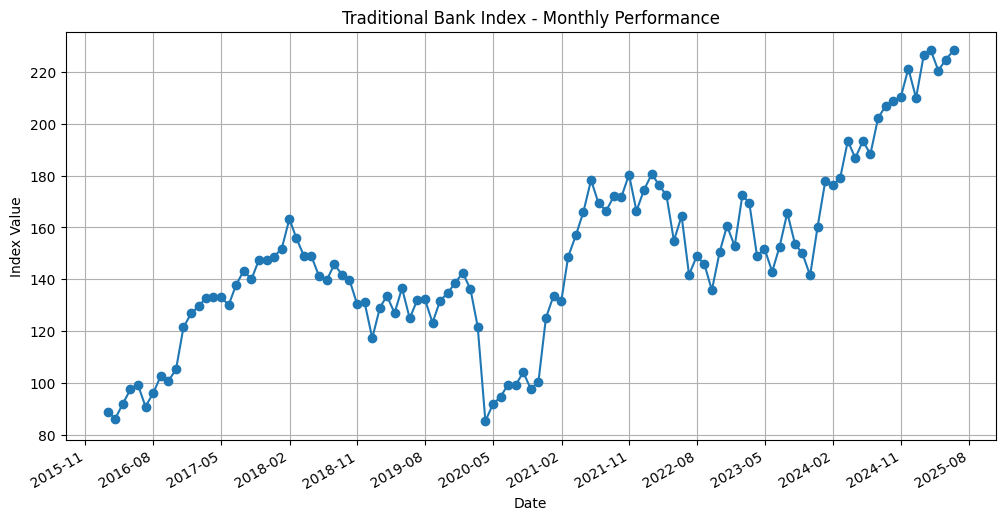


--- Script Finished ---


In [3]:
# --- Main Script ---

# Define your file paths
# IMPORTANT: Replace these with the actual paths to your Excel files.
# Use raw strings (r'...') for Windows paths if they contain backslashes,
# or use forward slashes.
file_path1_neo = r'Neo Banks Price History/All Neo Banks PH.xlsx'
file_path2_challenger = r'Challenger Banks Price History/All Challenger Banks PH.xlsx'
file_path3_traditional = r'Traditional Banks Price History/All Traditional Banks.xlsx'

# Process the first file
process_and_display_index(file_path1_neo, "Neo Bank")

# Process the second file
process_and_display_index(file_path2_challenger, "Challenger Bank")

process_and_display_index(file_path3_traditional, "Traditional Bank")

print("\n--- Script Finished ---")